# 불균형 데이터로 신용카드 사기탐지 모델 구현하기

## Step 0. 사기탐지 분류 모형 개요

### 금융 데이터의 특성 (Review)
- 1) 이종(heterogeneous) 데이터의 결합
- 2) <b>분포의 편향성(skewness)</b>
- 3) 분류 레이블의 불명확성
- 4) 변수의 다중공선성(multicollinearity)
- 5) 변수의 비선형성
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

사기탐지(Fraud Detection) 분류는 주로 2)와 관련한 금융 데이터의 특성을 가진 문제입니다. 

### 불균형 데이터의 머신러닝

- 데이터 불균형(Imbalanced Data): 머신러닝의 지도학습에서 분류하기 위한 각 클래스(레이블)에 해당하는 데이터의 양에 차이가 큰 경우
- 특정 클래스가 부족할 때 생기는 문제: (1) 과대적합, (2) 알고리즘이 수렴하지 않는 현상 발생


- 1) X (피처)의 불균형
    - 범주변수일 경우 범주에 따라 빈도가 낮을 수 있음
    - 고차원 피처 공간의 축소(Feature Transformation)
    - PCA, t-SNE 등의 알고리즘 사용
    
    
- 2) y (타겟)의 불균형
    - 여신(대출), 수신(적금), 보험(클레임), 카드(사기탐지), 거시경제(불황) 등 대부분의 금융 데이터는 희소 타겟 문제
    - 리샘플링(Resampling)으로 저빈도 데이터를 극복
    - 무선 과대표집(Random Oversampling), 무선 과소표집(Random Undersampling), SMOTE, Tomek Links 등의 알고리즘 사용

### 학습목표

- 1) 불균형 데이터 분류 문제에 대한 이해
- 2) 피처 변환 알고리즘의 이해
- 3) 과대적합 발생시 해결 방법 습득
- 4) 리샘플링 알고리즘에 대한 이해
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득

## Step 1. 데이터를 학습에 맞게 변환하기

- 데이터 소개
https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

### 문제 01. 데이터 확인하기

In [3]:
filepath = 'https://github.com/mchoimis/financialml/raw/main/fraud/'

In [4]:
# 파일 불러오기
df = pd.read_csv('fraud.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [50]:
# 로드한 데이터의 맨 윗 30개 행 확인하기
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [51]:
# Missing 여부 확인하기
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [5]:
# 불러온 데이터의 클래스 분포 확인하기
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [37]:
df['Class'].value_counts()
# print('Target class is ', '{0:0.4f}'. format( ), '%')

0    284315
1       492
Name: Class, dtype: int64

### 문제 02. 변수의 스케일 변환하기

### 참고: scikit-learn이 제공하는 스케일러 (Review)

scikit-learn에서 제공하는 피처 스케일러(scaler)
- `StandardScaler`: 기본 스케일, 각 피처의 평균을 0, 표준편차를 1로 변환
- `RobustScaler`: 위와 유사하지만 평균 대신 중간값(median)과 일분위, 삼분위값(quartile)을 사용하여 이상치 영향을 최소화
- `MinMaxScaler`: 모든 피처의 최대치와 최소치가 각각 1, 0이 되도록 스케일 조정
- `Normalizer`: 피처(컬럼)이 아니라 row마다 정규화되며, 유클리드 거리가 1이 되도록 데이터를 조정하여 빠르게 학습할 수 있게 함

<p> 스케일 조정을 하는 이유는 데이터의 값이 너무 크거나 작을 때 학습이 제대로 되지 않을 수도 있기 때문입니다. <b> 또한 스케일의 영향이 절대적인 분류기(예: knn과 같은 거리기반 알고리즘)의 경우, 스케일 조정을 필수적으로 검토해야 합니다. </b>
    
<p> 반면 어떤 항목은 원본 데이터의 분포를 유지하는 것이 나을 수도 있습니다. 예를 들어, 데이터가 거의 한 곳에 집중되어 있는 feature를 표준화시켜 분포를 같게 만들었을 때, 작은 단위의 변화가 큰 차이를 나타내는 것처럼 학습될 수도 있습니다. 또한 스케일의 영향을 크게 받지 않는 분류기(예: 트리 기반 앙상블 알고리즘)를 사용할 경우에도 성능이 준수하게 나오거나 과대적합(overfitting)의 우려가 적다면 생략할 수도 있습니다.
    
<p> <b>스케일 조정시 유의해야할 점은 원본 데이터의 의미를 잃어버릴 수 있다는 것입니다.</b> 최종적으로 답을 구하는 것이 목적이 아니라 모델의 해석이나 향후 다른 데이터셋으로의 응용이 더 중요할 때 원 피처에 대한 설명력을 잃어버린다면 모델 개선이 어려울 수도 있습니다. 이 점을 함께 고려하시면 좋겠습니다.

In [53]:
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# 데이터 스케일 조정하기
from sklearn.preprocessing import StandardScaler, RobustScaler

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] =  std_scaler.fit_transform(df['Time'].values.reshape(-1,1))


# 원 데이터에서 Time 컬럼과 Amount 컬럼 제외하기
df = df.drop(['Time'], axis=1)
df = df.drop(['Amount'],axis=1)

In [7]:
# 스케일 조정된 컬럼 추가하기
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

## 스케일 조정된 데이터 확인하기

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### 문제 03. 샘플 데이터 나누기

In [116]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 층위 샘플링으로 데이터 나누기
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1004)
i = 0
for train_index, test_index in sss.split(X, y):
    X_ori_train, y_ori_train = X.iloc[train_index], y.iloc[train_index]
    X_ori_test, y_ori_test = X.iloc[test_index], y.iloc[test_index] 
  # 채워주세요
X_ori_train.shape

0


(227845, 30)

In [14]:
# 클래스의 skew 정도가 매우 높기 때문에 클래스간 분포를 맞추는 것이 필요합니다.
# subsample 구축 전 셔플링을 통해 레이블이 한쪽에 몰려있지 않도록 하겠습니다.

df = df.sample(frac=1)

# 데이터 준비
fraud_df = df[df['Class']==1]
non_fraud_df =  df[df['Class']==0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# 데이터 셔플하기
new_df = normal_distributed_df.sample(frac=1)

# 셔플한 새로운 데이터 셋 확인
new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
88258,-0.326762,-0.689749,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,...,0.290187,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,1
266787,-0.085398,1.424993,1.823170,-0.556681,-1.750805,0.260344,1.968758,3.963545,-0.900886,1.031004,...,-0.055543,-0.181274,-0.658320,0.374245,0.624798,-0.369203,-0.966551,0.061359,-0.020964,0
150669,0.400490,-0.020086,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,...,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,1
198238,-0.272748,0.791360,-0.860265,1.593940,0.542153,0.900988,0.775143,-0.643818,1.432863,-0.163496,...,-0.029625,0.068398,0.385496,-0.593337,0.026426,1.116155,-0.225650,-0.367072,-0.242754,0
151006,-0.349231,-0.009515,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112785,-0.161441,-0.463482,-0.311657,0.583403,-0.209861,-1.199208,2.804925,3.323210,0.796800,0.538354,...,0.246493,-0.042852,-0.184478,-0.210613,1.030053,0.176612,0.304105,-0.129524,-0.120691,0
255556,-0.350151,1.315491,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,...,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,1
261056,-0.171276,1.369400,-0.408111,3.132944,-3.098030,5.803893,0.890609,-0.501474,-0.440054,0.591828,...,0.499568,0.098482,-0.538375,-0.217989,-1.042657,0.314389,0.543244,0.233851,0.119603,1
148584,-0.317287,-0.100085,2.042469,0.014301,-1.098162,0.392943,0.260591,-0.554461,0.024180,-0.269821,...,-0.192689,-0.408938,-0.821084,0.268017,-0.538873,-0.272861,0.166859,-0.099816,-0.078969,0


## Step 2. PCA와 t-SNE, SVD를 이용하여 차원 축소하기

### 참고: 차원축소 방법
    
- 주성분 분석(Principal Component Analysis)
- t-SNE (Stochastic Neighbor Embedding)
    - SNE는 n 차원에 분포된 이산 데이터를 k(n 이하의 정수) 차원으로 축소하며 거리 정보를 보존하되, 거리가 가까운 데이터의 정보를 우선하여 보존하기 위해 고안되었음
    - 단어 벡터와 같이 고차원 데이터를 시각화하는 데 가장 자주 쓰이는 알고리즘
    - SNE 학습과정에 사용되는 가우시안 분포는 t 분포에 비해 거리에 따른 확률 값 변화의 경사가 가파른 특징을 가지기 때문에 특정 거리 이상부터는 학습과정에 거의 반영이 되지 않는 문제점을 가지고 있음(Crowding Problem)
    - 이러한 문제점을 보완하기 위해 고안된 방법이 t-SNE: 학습과정에서 가우시안 분포 대신 t 분포를 이용
    - t-SNE는 보통 word2vec으로 임베딩한 단어벡터를 시각화하는데 쓰임
    
- 특이값 분해(Singular Value Decomposition)
- 그 외 잠재 의미분석(Latent Semantic Analysis), 행렬 인수분해(Matrix Factorization) 등

실무에서는 스케일이 매우 큰 실제 데이터를 분석하기 위해서, 여러 방법론을 융합하여 사용하는 것이 필요

### 문제 04. 차원 축소하기

In [92]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

# 차원 축소할 데이터 준비
X = new_df.drop('Class', axis=1)
y = new_df['Class']
print(X.shape)
# t-SNE  
X_reduced_tsne = TSNE(n_components=2, random_state=4).fit_transform(X.values) # hint: n_components == 임베딩 공간의 차원 크기 
print('t-SNE done')

# PCA 
X_reduced_pca = PCA(n_components=2,random_state=22).fit_transform(X.values)          # hint: n_components == 임베딩 공간의 차원 크기 
print('PCA done')

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=5, random_state=42).fit_transform(X.values)  #hint: n_components == 임베딩 공간의 차원 크기 
print('Truncated SVD done')

(984, 30)
t-SNE done
PCA done
Truncated SVD done


### 문제 05. 결과 시각화하기

In [60]:
X_reduced_svd

array([[ 1.14150731e+01, -4.19084494e+00,  2.59995943e+00,
         1.42979476e+00, -5.16514955e-01],
       [-4.16249204e-01, -3.74778647e-01,  1.83849546e-01,
        -8.07000629e-02, -3.65796174e-01],
       [ 4.51199304e+01, -6.91953765e+00, -1.57475900e+00,
         3.21379614e-02,  9.52116200e-01],
       ...,
       [ 7.19652996e+00, -3.23896112e+00,  2.69540289e+00,
         5.86239203e+00, -8.79690419e-01],
       [-1.85084813e-01, -4.34039052e-01,  3.66306861e-01,
         1.41692807e-01, -6.27259473e-01],
       [-2.80972331e-01, -3.96518802e-01,  1.43957438e-01,
        -3.32037947e-01, -2.18027313e-01]])

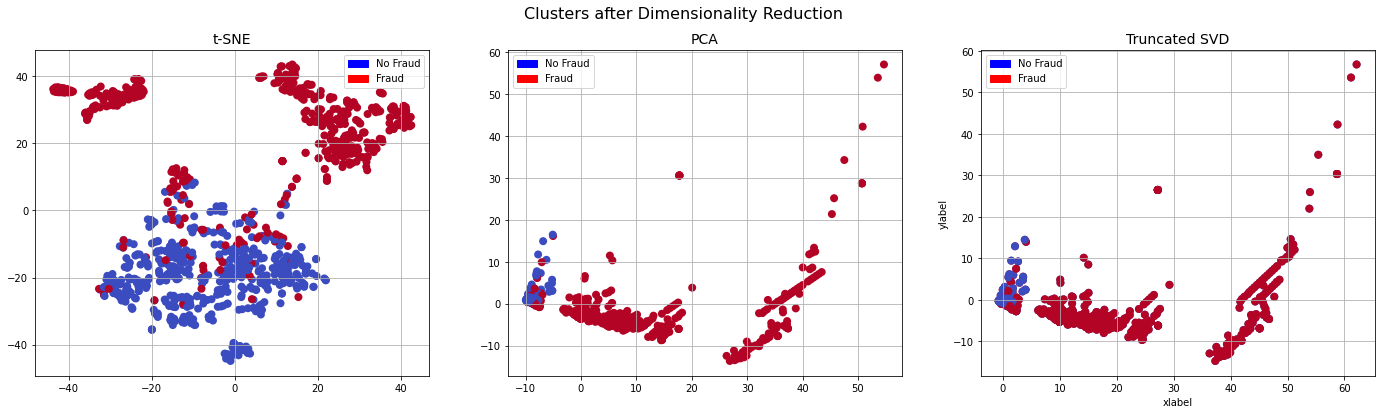

In [97]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
f.suptitle('Clusters after Dimensionality Reduction', fontsize=16)

# Label 범례 설정
labels = [plt.xlabel('xlabel'), plt.ylabel('ylabel')]
blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')

# t-SNE scatter plot
ax1.scatter( X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=(y==1), cmap='coolwarm', linewidths=2) ###
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)
ax1.legend(handles=[blue_patch, red_patch]) ###

# PCA scatter plot
ax2.scatter( X_reduced_pca[:,0],X_reduced_pca[:,1],c=(y == 1) , cmap='coolwarm', label='No Fraud', linewidths=2) ###
ax2.set_title('PCA', fontsize=14)
ax2.grid(True)
ax2.legend(handles=[blue_patch, red_patch]) ###

# TruncatedSVD scatter plot
ax3.scatter( X_reduced_svd[:,0],X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2) ###
ax3.scatter( X_reduced_svd[:,0],X_reduced_svd[:,1],  c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2) ###
ax3.set_title('Truncated SVD', fontsize=14)
ax3.grid(True)
ax3.legend(handles=[blue_patch, red_patch]) ###

plt.show()

## Step 3. Random Undersampling 으로 샘플 재구축하기

### 문제 06. 재구축 샘플로 분류모델 구현하기

In [62]:
# 재구축한 데이터의 클래스 분포 확인하기

new_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
88258,-0.326762,-0.689749,-1.644403,3.129852,-2.576977,3.415573,-0.448525,-1.241893,-1.991652,1.002665,...,0.290187,0.417762,-0.648576,-0.318617,-0.680413,0.389869,0.055750,0.394682,0.298821,1
266787,-0.085398,1.424993,1.823170,-0.556681,-1.750805,0.260344,1.968758,3.963545,-0.900886,1.031004,...,-0.055543,-0.181274,-0.658320,0.374245,0.624798,-0.369203,-0.966551,0.061359,-0.020964,0
150669,0.400490,-0.020086,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,...,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,1
198238,-0.272748,0.791360,-0.860265,1.593940,0.542153,0.900988,0.775143,-0.643818,1.432863,-0.163496,...,-0.029625,0.068398,0.385496,-0.593337,0.026426,1.116155,-0.225650,-0.367072,-0.242754,0
151006,-0.349231,-0.009515,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112785,-0.161441,-0.463482,-0.311657,0.583403,-0.209861,-1.199208,2.804925,3.323210,0.796800,0.538354,...,0.246493,-0.042852,-0.184478,-0.210613,1.030053,0.176612,0.304105,-0.129524,-0.120691,0
255556,-0.350151,1.315491,-0.242245,4.147186,-5.672349,6.493741,1.591168,-1.602523,-0.950463,0.722903,...,0.562030,0.249023,-0.480286,-0.286080,-1.153575,-0.035571,0.559628,0.409446,0.221048,1
261056,-0.171276,1.369400,-0.408111,3.132944,-3.098030,5.803893,0.890609,-0.501474,-0.440054,0.591828,...,0.499568,0.098482,-0.538375,-0.217989,-1.042657,0.314389,0.543244,0.233851,0.119603,1
148584,-0.317287,-0.100085,2.042469,0.014301,-1.098162,0.392943,0.260591,-0.554461,0.024180,-0.269821,...,-0.192689,-0.408938,-0.821084,0.268017,-0.538873,-0.272861,0.166859,-0.099816,-0.078969,0


In [63]:
# X와 y 데이터 셋 만들기
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [68]:
# 언더샘플링을 위한 샘플 데이터 구축
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [70]:
type(X_train)

pandas.core.frame.DataFrame

In [72]:
# 모델 인풋에 들어가기 위한 데이터의 형태 바꾸기
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [73]:
X_train

array([[-1.73315514e-01,  6.12093626e-01,  1.96683419e+00, ...,
         1.00795950e+00, -8.97151548e-02, -7.68217390e-02],
       [-3.49231307e-01,  3.21620626e-01,  1.93494646e+00, ...,
        -1.29953650e-01, -5.00768353e-02, -5.10818961e-02],
       [-3.49231307e-01, -6.62563555e-01,  1.34904594e+00, ...,
        -2.34222022e-01, -8.63329387e-03,  8.15148121e-04],
       ...,
       [ 7.50922071e-01,  7.36903940e-01,  1.52207986e+00, ...,
        -5.08398143e-01, -1.55514882e-02,  4.18807020e-02],
       [ 3.62428036e-01,  1.18122613e+00, -3.16318005e-01, ...,
         2.51714811e-01, -8.16701658e-02,  2.46557403e-02],
       [-3.46072819e-01, -5.97052354e-01,  1.26039176e+00, ...,
         9.36183233e-02, -2.72995841e-02,  1.96084126e-02]])

In [76]:
!pip instal

In [108]:
# 학습시킬 모델 로드하기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

classifiers = {
    "Logisitic Regression": LogisticRegression(),
    "K Nearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Random Forest Classifier": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "LightGBM Classifier": LGBMClassifier()
}
print(classifiers.items())

dict_items([('Logisitic Regression', LogisticRegression()), ('K Nearest', KNeighborsClassifier()), ('Support Vector Classifier', SVC()), ('Decision Tree Classifier', DecisionTreeClassifier()), ('Random Forest Classifier', RandomForestClassifier()), ('Gradient Boosting Classifier', GradientBoostingClassifier()), ('LightGBM Classifier', LGBMClassifier())])


In [110]:
# 모델별 cross validation 한 결과의 평균 정확도 점수 출력하기
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, ':', round(training_score.mean(), 2) * 100,'% accuracy')

LogisticRegression : 93.0 % accuracy
KNeighborsClassifier : 92.0 % accuracy
SVC : 93.0 % accuracy
DecisionTreeClassifier : 89.0 % accuracy
RandomForestClassifier : 93.0 % accuracy
GradientBoostingClassifier : 93.0 % accuracy
LGBMClassifier : 93.0 % accuracy


### 문제 07. 분류 결과 확인하기

In [ ]:
### 올바른 예

In [ ]:
# 모델별 분류결과 확인하기 (올바른 예)
from sklearn.metrics import classification_report
# classification_report(y_true, y_pred, target_names=['class 0', 'class 1'])
for key, classifier in classifiers.items():
    y_pred =   ####
    results =   ####
    print(classifier.__class__.__name__, '-------','\n', results)

In [107]:
y_test
y_train

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,

In [118]:
# 모델별 Confusion Matrix 확인하기 (올바른 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_ori_test)####
    cm = classification_report(y_ori_test, y_pred) ####
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.95      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.54     56962
weighted avg       1.00      0.97      0.98     56962
 

KNeighborsClassifier 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.93      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962
 

SVC 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.10      0.92      0.18        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1

In [117]:
# 모델별 Confusion Matrix 확인하기 (올바른 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_ori_test) ####
    cm = confusion_matrix(y_ori_test, y_pred) ####
    print(classifier.__class__.__name__, '\n', cm, '\n')

LogisticRegression 
 [[55262  1602]
 [    5    93]] 

KNeighborsClassifier 
 [[55418  1446]
 [    7    91]] 

SVC 
 [[56063   801]
 [    8    90]] 

DecisionTreeClassifier 
 [[50658  6206]
 [    0    98]] 

RandomForestClassifier 
 [[55449  1415]
 [    0    98]] 

GradientBoostingClassifier 
 [[54608  2256]
 [    0    98]] 

LGBMClassifier 
 [[54728  2136]
 [    0    98]] 



In [ ]:
### 잘못된 예  197개로만 하는거? 

In [114]:
X_test.shape

(197, 30)

In [111]:
# 모델별 분류결과 확인하기 (잘못된 예)
from sklearn.metrics import classification_report

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    results_wrong = classification_report(y_test, y_pred)   ####
    print(classifier.__class__.__name__, '-------','\n', results_wrong)

LogisticRegression ------- 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       103
           1       0.96      0.96      0.96        94

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197

KNeighborsClassifier ------- 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       103
           1       0.97      0.94      0.95        94

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197

SVC ------- 
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       103
           1       0.97      0.94      0.95        94

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197


In [112]:
# 모델별 Confusion Matrix 확인하기 (잘못된 예)
from sklearn.metrics import confusion_matrix

for key, classifier in classifiers.items():
    y_pred = classifier.predict(X_test) ####
    cm_wrong = confusion_matrix(y_test, y_pred)  ####
    print(classifier.__class__.__name__, '\n', cm_wrong, '\n')

LogisticRegression 
 [[99  4]
 [ 4 90]] 

KNeighborsClassifier 
 [[100   3]
 [  6  88]] 

SVC 
 [[100   3]
 [  6  88]] 

DecisionTreeClassifier 
 [[96  7]
 [ 6 88]] 

RandomForestClassifier 
 [[100   3]
 [  5  89]] 

GradientBoostingClassifier 
 [[98  5]
 [ 4 90]] 

LGBMClassifier 
 [[100   3]
 [  4  90]] 



## Step 4. SMOTE 로 Oversampling 하기 

### 참고:

- 리샘플링(Synthetic Minority Oversampling Technique)

- 모델 파라미터 조정
    - `scale_pos_weight`
    - `is_unbalance`
    - `{class_label: weight}`

### 문제 08. SMOTE로 Oversampling하기

In [81]:
!pip install imblearn

In [86]:
# X와 y 데이터 셋 만들기
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold, StratifiedKFold

X = df.drop('Class', axis=1)
y = df['Class']

# 층위 샘플링으로 데이터 나누기
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1004)
for train_index, test_index in sss.split(X, y):
    original_Xtrain, original_ytrain = X.iloc[train_index], y.iloc[train_index]
    original_Xtest, original_ytest = X.iloc[test_index], y.iloc[test_index] 

df_strat_train

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
152751,-0.289460,0.055596,1.942608,-0.542794,0.142107,0.394402,-0.895053,0.020459,-1.130101,0.151194,...,-0.235445,-0.090819,0.057384,0.283326,-0.390505,-0.637745,0.445036,-0.049361,-0.058039,0
65115,-0.113984,-0.913469,1.048150,-0.747197,0.904007,0.064860,-0.993259,0.575744,-0.885446,0.442703,...,-0.090277,-0.164298,-0.410311,0.031829,-0.264520,0.001849,0.974880,-0.042120,0.002845,0
148972,-0.253477,-0.093389,0.018612,1.497740,0.041213,1.355554,0.519167,-0.787381,0.861103,-0.560471,...,0.224359,0.209940,1.093485,-0.259090,-0.004448,-0.454182,0.195532,-0.018507,0.221415,0
37585,-0.312449,-1.174861,-0.642551,-0.315661,2.245626,-2.598089,-1.298330,-0.459654,-0.583559,0.214050,...,-0.227865,-0.020332,0.282045,-0.287024,0.288016,0.350529,-0.183439,0.299336,0.116911,0
213785,-0.146288,0.938723,-0.986341,0.716497,-1.178013,-1.390039,1.563153,3.905291,-1.098825,1.996828,...,-0.247206,0.105690,-0.028453,0.218458,0.603703,-0.652089,0.303028,-0.240335,-0.089460,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180254,-0.247400,0.624160,1.978125,-0.005621,-1.790609,1.212133,0.514797,-0.629173,0.445392,-0.158527,...,-0.346445,0.067396,0.269603,-0.059665,-0.504496,0.419170,-0.478606,-0.033090,-0.076654,0
125363,-0.041459,-0.361730,-0.737810,0.208040,1.166766,-1.236548,-1.074573,-0.450401,-0.111930,0.352861,...,-0.337687,-0.099758,-0.090573,0.006259,-0.089000,-0.205820,1.115244,-0.095773,0.041535,0
32282,-0.253277,-1.223252,-2.274497,2.396037,-1.283805,1.557928,-1.596172,-0.593047,-1.297165,1.787662,...,-0.737535,0.370955,0.387920,0.478874,-0.133455,-1.132829,-0.449863,-1.074286,-0.084538,0
231945,-0.196504,1.098700,-0.119708,-1.129670,0.640270,-2.056060,-0.465652,-0.855713,-0.796691,-0.126209,...,-0.430238,-0.004412,0.540411,-0.004672,0.101075,-0.932016,-0.265492,0.146261,0.057619,0


In [120]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled =  sm.fit_resample(X_ori_train, y_ori_train) ####


print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (227845, 30)
Before SMOTE, original y_train: (227845,)
After  SMOTE, resampled original X_train: (454902, 30)
After  SMOTE, resampled original y_train: (454902,) 

Before SMOTE,     fraud counts: 394
Before SMOTE, non-fraud counts: 227451
After  SMOTE,     fraud counts: 227451
After  SMOTE, non-fraud counts: 227451


In [87]:
# 이렇게 하면 test데이터도 늘려져서 안됨!!!!!!!!

from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_resampled, y_resampled =  sm.fit_resample(X, y) ####


print('Before SMOTE, original X_train: {}'.format(original_Xtrain.shape)) 
print('Before SMOTE, original y_train: {}'.format(np.array(original_ytrain).shape))
print('After  SMOTE, resampled original X_train: {}'.format(X_resampled.shape)) 
print('After  SMOTE, resampled original y_train: {} \n'.format(np.array(y_resampled).shape))

print("Before SMOTE,     fraud counts: {}".format(sum(np.array(original_ytrain)==1)))
print("Before SMOTE, non-fraud counts: {}".format(sum(np.array(original_ytrain)==0)))
print("After  SMOTE,     fraud counts: {}".format(sum(np.array(y_resampled)==1)))
print("After  SMOTE, non-fraud counts: {}".format(sum(np.array(y_resampled)==0)))

Before SMOTE, original X_train: (227845, 30)
Before SMOTE, original y_train: (227845,)
After  SMOTE, resampled original X_train: (568630, 30)
After  SMOTE, resampled original y_train: (568630,) 

Before SMOTE,     fraud counts: 394
Before SMOTE, non-fraud counts: 227451
After  SMOTE,     fraud counts: 284315
After  SMOTE, non-fraud counts: 284315


### 문제 09. 재구축한 샘플로 분류 모형 구현하기(2가지 방법)

In [ ]:
# 방법 1: 모델의 파라미터를 조정하는 방법 

In [88]:
from sklearn.metrics import accuracy_score, recall_score
# f1_score, roc_auc_score, precision_score

In [135]:
# Logistic Regression 모델의 weight 파라미터 지정하기

w = {0 : 1, 1 : 99}  ## 불균형 클래스 weight 파라미터 지정

# 모델 피팅
logreg_weighted = LogisticRegression(random_state=0, class_weight=w)  ###
logreg_weighted.fit(original_Xtrain, original_ytrain) ###

# 예측값 구하기
y_pred = logreg_weighted.predict(original_Xtest) ###

# 예측 결과값 확인하기
print('Logistic Regression ------ Weighted')
print(f'Accuracy: {accuracy_score(original_ytest, y_pred)}')###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred)}')###

print('\n')
print(f'Recall: {recall_score(original_ytest, y_pred)}')###


Logistic Regression ------ Weighted
Accuracy: 0.9959095537375794


Confusion Matrix: 
[[56640   224]
 [    9    89]]


Recall: 0.9081632653061225


In [136]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(original_ytest,y_pred, target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      1.00      0.91      1.00      0.95      0.91     56864
      fraud       0.28      0.91      1.00      0.43      0.95      0.90        98

avg / total       1.00      1.00      0.91      1.00      0.95      0.91     56962



In [ ]:
# 방법 2: Resampling 으로 재구축한 샘플을 이용하는 방법

In [130]:
# 재구축한 샘플 데이터로 모델 피팅하기
logreg_resampled = LogisticRegression(random_state=0)###
logreg_resampled.fit(X_resampled, y_resampled) ###

# 예측값 구하기
y_pred = logreg_resampled.predict(original_Xtest)

# 예측 결과값 확인하기
print('Logistic Regression ------ Resampled Data')
print(f'Accuracy: {accuracy_score(original_ytest, y_pred)}') ###

print('\n')
print(f'Confusion Matrix: \n{confusion_matrix(original_ytest, y_pred) }') ###

print('\n')
print(f'Recall: {recall_score(original_ytest, y_pred)}') ###

Logistic Regression ------ Resampled Data
Accuracy: 0.9755099891155508


Confusion Matrix: 
[[55474  1390]
 [    5    93]]


Recall: 0.9489795918367347


In [134]:
# imblearn 패키지를 이용하여 예측 결과 확인하기
from imblearn.metrics import classification_report_imbalanced

label = ['non-fraud', 'fraud'] 
print(classification_report_imbalanced(original_ytest,y_pred, target_names=label))

                   pre       rec       spe        f1       geo       iba       sup

  non-fraud       1.00      0.98      0.95      0.99      0.96      0.93     56864
      fraud       0.06      0.95      0.98      0.12      0.96      0.92        98

avg / total       1.00      0.98      0.95      0.99      0.96      0.93     56962



## Step 5. 요약

- 1) 불균형 분류 문제에 대한 이해: 사기탐지 데이터
- 2) 피처 변환 알고리즘의 이해: <b>PCA</b>, <b>t-SNE</b>, <b>SVD</b>
- 3) 과대적합 발생시 해결 방법 습득: 모델 파라미터 조정, 샘플 재구축
- 4) 리샘플링 알고리즘에 대한 이해: <b>Random Undersampling</b>, <b>Random Oversampling</b>, <b>SMOTE Oversampling</b> 등
- 5) 불균형 데이터를 이용한 분류 결과의 올바른 해석 방법 습득: `classification_report_imbalanced` 이용하기